<a href="https://colab.research.google.com/github/hjangir080/EmotionAwareMusicGeneration/blob/main/v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Version 3

# Install Dependencies & Imports

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import BertModel, BertTokenizer
from tqdm import tqdm


import IPython.display as ipd
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

# Music-Aware Text Encoder

Encodes text using BERT while enhancing music-related terms with specialized embeddings. Creates hybrid text-music representations for better audio conditioning.

In [4]:
class MuLANTextEncoder(nn.Module):
    """Text encoder based on BERT with MuLAN-style additions for music understanding"""
    def __init__(self, bert_model="bert-base-uncased", embedding_dim=512):
        super(MuLANTextEncoder, self).__init__()
        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model)
        self.tokenizer = BertTokenizer.from_pretrained(bert_model)

        # Project BERT outputs to our embedding space
        self.projection = nn.Linear(self.bert.config.hidden_size, embedding_dim)

        # Music-specific token embeddings (words related to music semantics)
        self.music_token_embedding = nn.Embedding(1000, embedding_dim)
        self.music_vocab = self._create_music_vocab()

    def _create_music_vocab(self):
        """Create vocabulary mapping for music-specific terms"""
        music_terms = [
            "tempo", "rhythm", "melody", "harmony", "bass", "treble",
            "major", "minor", "piano", "guitar", "drums", "strings",
            "loud", "soft", "fast", "slow", "staccato", "legato",
            # Emotions
            "happy", "sad", "angry", "fearful", "tender", "excited",
            # Instruments
            "violin", "cello", "flute", "trumpet", "saxophone", "harp",
            "synthesizer", "electric guitar", "acoustic guitar", "bass guitar",
            # Musical styles
            "classical", "jazz", "rock", "electronic", "ambient", "folk",
            "pop", "hip hop", "blues", "country", "metal", "funk",
            # Descriptive terms
            "bright", "dark", "warm", "cold", "mellow", "harsh",
            "smooth", "rough", "ethereal", "gritty", "lush", "sparse",
            "uplifting", "melancholic", "energetic", "calm", "tense", "relaxed"
        ]
        return {term: i for i, term in enumerate(music_terms)}

    def forward(self, text):
        """Encode text into music-aware embeddings"""
        # Tokenize input
        tokens = self.tokenizer(text, return_tensors="pt",
                               padding=True, truncation=True, max_length=512)

        # Move to the same device as the model
        tokens = {k: v.to(self.bert.device) for k, v in tokens.items()}

        # Get BERT embeddings
        with torch.no_grad():
            outputs = self.bert(**tokens)

        # Use the [CLS] token embedding as sequence representation
        sequence_embedding = outputs.last_hidden_state[:, 0, :]

        # Project to our embedding space
        projected_embedding = self.projection(sequence_embedding)

        # Extract and enhance music-specific terms
        music_embedding = self._enhance_music_terms(text, projected_embedding)

        return music_embedding

    def _enhance_music_terms(self, text, embedding):
        """Enhance embeddings with music-specific token information"""
        # Check if text is a list or a single string
        if isinstance(text, str):
            text = [text]  # Convert to list for consistent processing

        batch_enhanced = []

        for i, t in enumerate(text):
            t_lower = t.lower()

            # Initialize music embedding contribution
            music_contrib = torch.zeros_like(embedding[i])
            count = 0

            # Look for music terms - use word boundaries to avoid partial matches
            for term, idx in self.music_vocab.items():
                # Check for word boundaries to find whole words
                import re
                matches = re.findall(r'\b' + re.escape(term) + r'\b', t_lower)
                if matches:
                    term_tensor = torch.tensor([idx], device=embedding.device)
                    music_contrib += self.music_token_embedding(term_tensor).squeeze(0)
                    count += 1

            # Add weighted music embedding if any terms found
            if count > 0:
                enhanced = embedding[i] + (music_contrib / count) * 0.3  # 30% contribution
            else:
                enhanced = embedding[i]

            batch_enhanced.append(enhanced)

        return torch.stack(batch_enhanced)

# Neural Audio Processing

SoundStream architecture converts audio to latent representations and reconstructs high-fidelity waveforms. Uses residual vector quantization for efficient compression.

In [5]:
class SoundStreamEncoder(nn.Module):
    """Audio encoder inspired by SoundStream architecture"""
    def __init__(self, input_channels=1, embedding_dim=512):
        super(SoundStreamEncoder, self).__init__()

        # Convolutional encoder
        self.encoder = nn.Sequential(
            # Initial convolution
            nn.Conv1d(input_channels, 32, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            # Downsampling convolutions
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),  # Downsample 2x
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),  # Downsample 2x
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),  # Downsample 2x
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),  # Downsample 2x
            nn.BatchNorm1d(512),
            nn.ReLU(),

            # Additional convolutions
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )

        # Projection to embedding space
        self.projection = nn.Linear(512, embedding_dim)

        # Quantizer (VQ layer)
        self.codebook_size = 1024
        self.codebook = nn.Embedding(self.codebook_size, embedding_dim)

        # Residual vector quantizer
        self.num_quantizers = 8
        self.codebook_dim = embedding_dim // self.num_quantizers
        self.codebooks = nn.ModuleList([
            nn.Embedding(self.codebook_size, self.codebook_dim)
            for _ in range(self.num_quantizers)
        ])

    def vector_quantize(self, x, codebook):
        """
        Vector quantization implementation with improved efficiency and numerical stability
        x: (batch_size, codebook_dim)
        """
        # Calculate squared L2 norm - more stable implementation
        x_norm = torch.sum(x**2, dim=1, keepdim=True)
        codebook_norm = torch.sum(codebook.weight**2, dim=1)

        # Calculate dot product
        dot_product = torch.matmul(x, codebook.weight.t())

        # Calculate distance using the expanded form of Euclidean distance
        d = x_norm + codebook_norm - 2 * dot_product

        # Prevent numerical instability
        d = torch.clamp(d, min=1e-5)

        # Find nearest neighbor
        indices = torch.argmin(d, dim=1)
        quantized = codebook(indices)

        # Straight-through estimator
        quantized_st = x + (quantized - x).detach()

        # Calculate VQ loss components for training
        commitment_loss = F.mse_loss(x, quantized.detach())
        codebook_loss = F.mse_loss(quantized, x.detach())

        return quantized_st, indices, commitment_loss + codebook_loss

    def forward(self, x):
        """
        Encode audio into latent representations
        x shape: [batch_size, 1, time]
        """
        # Apply convolutional encoder
        encoded = self.encoder(x)  # [batch_size, 512, time/16]

        # Global pooling to get fixed-size representation
        pooled = F.adaptive_avg_pool1d(encoded, 1).squeeze(-1)  # [batch_size, 512]

        # Project to embedding space
        embedding = self.projection(pooled)  # [batch_size, embedding_dim]

        # Reshape for residual VQ
        batch_size = embedding.shape[0]
        reshaped = embedding.view(batch_size, self.num_quantizers, self.codebook_dim)

        # Apply residual vector quantization
        quantized_list = []
        indices_list = []

        for i in range(self.num_quantizers):
            q, idx = self.vector_quantize(reshaped[:, i], self.codebooks[i])
            quantized_list.append(q)
            indices_list.append(idx)

        # Reshape back
        quantized = torch.cat(quantized_list, dim=1).view(batch_size, -1)

        # Combine with encoded for temporal information
        return quantized, encoded

In [6]:
class SoundStreamDecoder(nn.Module):
    """Audio decoder inspired by SoundStream architecture"""
    def __init__(self, embedding_dim=512, output_channels=1):
        super(SoundStreamDecoder, self).__init__()

        # Project embedding to the right dimension for the decoder
        self.pre_decoder = nn.Linear(embedding_dim, 512)

        # Convolutional decoder
        self.decoder = nn.Sequential(
            # Initial convolution
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            # Upsampling convolutions using transposed convolutions
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),  # Upsample 2x
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),  # Upsample 2x
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),   # Upsample 2x
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),    # Upsample 2x
            nn.BatchNorm1d(32),
            nn.ReLU(),

            # Final convolution to get to the right number of channels
            nn.Conv1d(32, output_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()  # Output in [-1, 1] range for audio
        )

    def forward(self, z, encoded=None, length=16000):
        """
        Decode latent representation to audio
        z shape: [batch_size, embedding_dim]
        encoded shape (optional): [batch_size, 512, time/16]
        """
        # Project to the right dimension
        z_proj = self.pre_decoder(z)  # [batch_size, 512]

        if encoded is not None:
            # Use the temporal information from the encoder
            z_temporal = z_proj.unsqueeze(-1) * F.adaptive_avg_pool1d(encoded, encoded.size(-1))
        else:
            # Create a temporal dimension
            time_steps = length // 16  # Depends on the encoder downsampling
            z_temporal = z_proj.unsqueeze(-1).repeat(1, 1, time_steps)

        # Apply convolutional decoder
        decoded = self.decoder(z_temporal)  # [batch_size, output_channels, time]

        return decoded

# Music Generation UNet

Hierarchical Audio Synthesis
UNet architecture with skip connections generates high-resolution audio. Text conditioning injected through projection layers enables semantic control over output.

In [7]:
class AttentionBlock(nn.Module):
    """Self-attention block for the UNet architecture"""
    def __init__(self, channels):
        super(AttentionBlock, self).__init__()
        self.channels = channels

        self.norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.qkv_proj = nn.Conv1d(channels, channels * 3, kernel_size=1)
        self.out_proj = nn.Conv1d(channels, channels, kernel_size=1)

    def forward(self, x):
        batch, channels, length = x.shape
        assert channels == self.channels

        # Apply normalization
        h = self.norm(x)

        # Compute query, key, value
        qkv = self.qkv_proj(h)
        qkv = qkv.reshape(batch, 3, channels, length)
        q, k, v = qkv[:, 0], qkv[:, 1], qkv[:, 2]

        # Compute attention
        scale = 1.0 / (channels ** 0.5)
        attention = torch.einsum('bct,bcs->bts', q, k) * scale
        attention = F.softmax(attention, dim=2)

        # Apply attention
        output = torch.einsum('bts,bcs->bct', attention, v)

        # Project back to original dimension
        output = self.out_proj(output)

        # Residual connection
        return x + output

In [8]:
class TextConditionedResidualBlock(nn.Module):
    """Residual block with text conditioning for UNet architecture"""
    def __init__(self, in_channels, out_channels, text_channels, dropout=0.1):
        super(TextConditionedResidualBlock, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.norm1 = nn.GroupNorm(num_groups=8, num_channels=in_channels)
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)

        self.norm2 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)

        # Text conditioning
        self.text_proj = nn.Linear(text_channels, out_channels)

        # Shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, text_embed):
        """
        Forward pass with text conditioning
        x: [batch_size, in_channels, time]
        text_embed: [batch_size, text_channels]
        """
        # Check channels match expected dimensions
        if x.size(1) != self.in_channels:
            print(f"Warning: Input channels {x.size(1)} don't match expected {self.in_channels}")
            # Adjust the layer to match the input dynamically
            if not hasattr(self, 'adjusted_norm1') or self.adjusted_norm1.num_channels != x.size(1):
                self.adjusted_norm1 = nn.GroupNorm(
                    num_groups=min(8, x.size(1)),
                    num_channels=x.size(1)
                ).to(x.device)
            norm1 = self.adjusted_norm1
        else:
            norm1 = self.norm1

        # First convolution block
        h = norm1(x)
        h = F.silu(h)
        h = self.conv1(h)

        # Apply text conditioning
        text_embed = self.text_proj(text_embed).unsqueeze(-1)
        text_embed = text_embed.expand(-1, -1, h.size(-1))
        h = h + text_embed

        # Second convolution block
        h = self.norm2(h)
        h = F.silu(h)
        h = self.dropout(h)
        h = self.conv2(h)

        # For shortcut, adjust if dimensions don't match
        if x.size(1) != self.in_channels and x.size(1) != self.out_channels:
            shortcut = nn.Conv1d(x.size(1), self.out_channels, kernel_size=1).to(x.device)
            return h + shortcut(x)
        else:
            # Regular skip connection
            return h + self.shortcut(x)

In [9]:
class MusicConditionedUNet(nn.Module):
    """UNet-style model for high-resolution audio generation conditioned on text"""
    def __init__(self, input_channels=1, output_channels=1, base_channels=32, embedding_dim=512):
        super(MusicConditionedUNet, self).__init__()

        # Initial convolution
        self.initial_conv = nn.Conv1d(input_channels, base_channels, kernel_size=3, padding=1)

        # Encoder (downsampling) blocks
        self.down1 = self._make_down_block(base_channels, base_channels*2, embedding_dim)
        self.down2 = self._make_down_block(base_channels*2, base_channels*4, embedding_dim)
        self.down3 = self._make_down_block(base_channels*4, base_channels*8, embedding_dim)
        self.down4 = self._make_down_block(base_channels*8, base_channels*16, embedding_dim)

        # Middle blocks
        self.mid_resblock1 = TextConditionedResidualBlock(base_channels*16, base_channels*16, embedding_dim)
        self.mid_attn = AttentionBlock(base_channels*16)
        self.mid_resblock2 = TextConditionedResidualBlock(base_channels*16, base_channels*16, embedding_dim)

        # Decoder (upsampling) blocks - adjust input channels to account for skip connections
        self.up4 = self._make_up_block(base_channels*32, base_channels*8, embedding_dim)  # 16+16 channels
        self.up3 = self._make_up_block(base_channels*16, base_channels*4, embedding_dim)  # 8+8 channels
        self.up2 = self._make_up_block(base_channels*8, base_channels*2, embedding_dim)   # 4+4 channels
        self.up1 = self._make_up_block(base_channels*4, base_channels, embedding_dim)     # 2+2 channels

        # Final convolution
        self.final_norm = nn.GroupNorm(num_groups=8, num_channels=base_channels)
        self.final_conv = nn.Conv1d(base_channels, output_channels, kernel_size=3, padding=1)

    def _make_down_block(self, in_channels, out_channels, text_channels):
        return nn.ModuleList([
            TextConditionedResidualBlock(in_channels, in_channels, text_channels),
            TextConditionedResidualBlock(in_channels, out_channels, text_channels),
            nn.Conv1d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)  # Downsample
        ])

    def _make_up_block(self, in_channels, out_channels, text_channels):
        return nn.ModuleList([
            TextConditionedResidualBlock(in_channels, in_channels, text_channels),
            TextConditionedResidualBlock(in_channels, out_channels, text_channels),
            nn.ConvTranspose1d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)  # Upsample
        ])

    def forward(self, x, text_embedding):
        """Memory-optimized forward pass with text conditioning"""
        # Enable gradient checkpointing if using for training
        checkpoint_fn = lambda module, inputs: torch.utils.checkpoint.checkpoint(module, *inputs)

        # Initial convolution
        h = self.initial_conv(x)

        # Store dimensions rather than full tensors
        skip_dims = []
        skips = []

        # Down blocks
        for i, down_block in enumerate([self.down1, self.down2, self.down3, self.down4]):
            h = down_block[0](h, text_embedding)
            h = down_block[1](h, text_embedding)

            # Save skip connection and its dimensions
            skips.append(h)
            skip_dims.append(h.shape)

            # Downsample
            h = down_block[2](h)

            # Clear cache periodically
            if i % 2 == 1:
                torch.cuda.empty_cache()

        # Middle blocks
        h = self.mid_resblock1(h, text_embedding)
        h = self.mid_attn(h)
        h = self.mid_resblock2(h, text_embedding)

        # Up blocks with skip connections
        for i, up_block in enumerate([self.up4, self.up3, self.up2, self.up1]):
            # Get the skip connection
            skip = skips.pop()

            # Match dimensions
            if h.shape[2] != skip.shape[2]:
                min_len = min(h.shape[2], skip.shape[2])
                h = h[:, :, :min_len]
                skip = skip[:, :, :min_len]

            # Concatenate
            h = torch.cat([h, skip], dim=1)

            # Apply 1x1 conv if needed
            if h.shape[1] != up_block[0].in_channels:
                # Create an on-the-fly 1x1 convolution
                h = nn.Conv1d(h.shape[1], up_block[0].in_channels,
                            kernel_size=1).to(h.device)(h)

            # Apply up_block operations
            h = up_block[0](h, text_embedding)
            h = up_block[1](h, text_embedding)

            # Only upsample if not the last block
            if i < 3:  # Not the last block
                h = up_block[2](h)

            # Clear cache periodically
            torch.cuda.empty_cache()

        # Final processing
        h = self.final_norm(h)
        h = F.silu(h)
        h = self.final_conv(h)

        # Ensure output matches input dimensions
        if h.shape[2] != x.shape[2]:
            if h.shape[2] < x.shape[2]:
                h = F.pad(h, (0, x.shape[2] - h.shape[2]))
            else:
                h = h[:, :, :x.shape[2]]

        return h

# Full Pipeline Integration

End-to-End Generation
Combines all components for text-to-music synthesis. Uses diffusion process with text conditioning to gradually denoise random input into coherent audio.

In [10]:
class TextToMusicGenerationModel(nn.Module):
    """Full text-to-music generation model combining all components"""
    def __init__(self, embedding_dim=512):
        super(TextToMusicGenerationModel, self).__init__()

        # Text encoder
        self.text_encoder = MuLANTextEncoder(embedding_dim=embedding_dim)

        # Audio encoder for conditioning
        self.audio_encoder = SoundStreamEncoder(embedding_dim=embedding_dim)

        # Audio decoder for reconstruction
        self.audio_decoder = SoundStreamDecoder(embedding_dim=embedding_dim)

        # UNet for high-resolution generation
        self.unet = MusicConditionedUNet(embedding_dim=embedding_dim)

    def encode_text(self, text):
        """Encode text description"""
        return self.text_encoder(text)

    def encode_audio(self, audio):
        """Encode audio"""
        return self.audio_encoder(audio)

    def decode_audio(self, z, encoded=None, length=16000):
        """Decode latent representation to audio"""
        return self.audio_decoder(z, encoded, length)

    def generate_from_text(self, text, noise_level=0.9, steps=50, length=16000):
        """
        Generate audio conditioned on text
        """
        # Determine device
        device = next(self.parameters()).device

        # Get text embedding using the forward method directly
        text_embedding = self.text_encoder(text)
        print(f"Text encoded, embedding shape: {text_embedding.shape}")

        # Create initial noise
        audio = torch.randn(1, 1, length, device=device) * noise_level
        print(f"Initial noise created with shape: {audio.shape}")

        # Diffusion sampling loop
        with torch.no_grad():
            for i in range(steps):
                # Get model prediction
                update = self.unet(audio, text_embedding)

                # Calculate noise scale for this step
                noise_scale = noise_level * (1.0 - (i / steps))

                # Make sure dimensions match before combining
                if audio.shape[2] != update.shape[2]:
                    min_len = min(audio.shape[2], update.shape[2])
                    audio = audio[:, :, :min_len]
                    update = update[:, :, :min_len]

                # Apply the update with noise scheduling
                audio = audio * (1.0 - noise_scale) + update * noise_scale

                # Optional: Print progress
                if i % 10 == 0:
                    print(f"Step {i}/{steps}, audio range: {audio.min().item():.3f} to {audio.max().item():.3f}")

                # Free up memory
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        # Normalize final audio to [-1, 1] range
        audio = torch.clamp(audio, -1.0, 1.0)

        return audio.cpu().numpy()

    def forward(self, audio_input=None, text_input=None, mode='train'):
        """
        Forward pass through the model
        Modes:
        - 'train': Train the full model (reconstruction + generation)
        - 'encode_text': Only encode text
        - 'encode_audio': Only encode audio
        - 'generate': Generate audio from text
        """
        if mode == 'encode_text' and text_input is not None:
            return self.encode_text(text_input)

        elif mode == 'encode_audio' and audio_input is not None:
            return self.encode_audio(audio_input)

        elif mode == 'generate' and text_input is not None:
            # Use default parameters for generation
            return self.generate_from_text(text_input)

        elif mode == 'train':
            if audio_input is None or text_input is None:
                raise ValueError("Both audio_input and text_input are required for training")

            # Encode text
            text_embedding = self.encode_text(text_input)

            # Encode audio
            quantized, encoded = self.encode_audio(audio_input)

            # Decode audio (reconstruction path)
            reconstructed = self.decode_audio(quantized, encoded, audio_input.shape[-1])

            # UNet for high-resolution details (enhancement path)
            enhanced = self.unet(reconstructed, text_embedding)

            return {
                "reconstructed": reconstructed,
                "enhanced": enhanced,
                "quantized": quantized,
                "encoded": encoded,
                "text_embedding": text_embedding
            }

        else:
            raise ValueError(f"Unknown mode: {mode}")

# Training & Evaluation

Training Mechanics
Jointly optimizes reconstruction and diffusion losses. Uses MSE between original/reconstructed audio and predicted noise for stable training.

In [11]:
def train_step(model, audio_batch, text_batch, optimizer, device, lambda_rec=1.0, lambda_enhance=0.5):
    """Single training step for the text-to-music model"""
    # Move data to device
    audio_batch = audio_batch.to(device)

    # Forward pass
    outputs = model(audio_batch, text_batch, mode='train')

    # Calculate losses
    # Reconstruction loss - compare original audio with reconstructed audio
    rec_loss = F.mse_loss(outputs["reconstructed"], audio_batch)

    # Enhancement loss - compare enhanced audio with original audio
    enhance_loss = F.mse_loss(outputs["enhanced"], audio_batch)

    # Total loss
    loss = lambda_rec * rec_loss + lambda_enhance * enhance_loss

    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Gradient clipping for stability
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # Update weights
    optimizer.step()

    return {
        "loss": loss.item(),
        "rec_loss": rec_loss.item(),
        "enhance_loss": enhance_loss.item()
    }

In [12]:
def example_usage():
    # Initialize model
    model = TextToMusicGenerationModel(embedding_dim=512)
    model.to(device)

    # Set up optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Example training loop
    for epoch in range(num_epochs):
        for audio_batch, text_batch in dataloader:
            metrics = train_step(model, audio_batch, text_batch, optimizer, device)
            print(f"Epoch {epoch}, Loss: {metrics['loss']:.4f}")

    # Example generation
    text_prompt = "A calm classical piano piece with a melancholic melody"
    generated_audio = model.generate_from_text(text_prompt, steps=100)

    # Save the generated audio (pseudo-code)
    save_audio(generated_audio.cpu().numpy(), "generated_music.wav")

In [13]:
def display_audio_in_colab(audio_data, sample_rate=16000, filename="generated_audio.wav"):
    """
    Display and save audio data in Colab notebook
    Works with both NumPy arrays and PyTorch tensors
    """
    # Convert to numpy array if it's a torch tensor
    if isinstance(audio_data, torch.Tensor):
        audio_np = audio_data.squeeze().detach().cpu().numpy()
    else:
        # Already a numpy array
        audio_np = audio_data.squeeze()

    # Ensure the audio is clipped to the valid range
    audio_np = np.clip(audio_np, -1.0, 1.0)

    # Display waveform
    plt.figure(figsize=(10, 4))
    plt.plot(audio_np)
    plt.title("Generated Audio Waveform")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    # Scale for 16-bit WAV
    audio_int16 = (audio_np * 32767).astype(np.int16)

    # Save as WAV file
    wavfile.write(filename, sample_rate, audio_int16)

    # Display playable audio in the notebook
    print("Generated audio playback:")
    return ipd.Audio(audio_np, rate=sample_rate)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Text encoded, embedding shape: torch.Size([1, 512])
Initial noise created with shape: torch.Size([1, 1, 16000])
Step 0/50, audio range: -1.531 to 1.496
Step 10/50, audio range: -5.277 to 2.343
Step 20/50, audio range: -4.804 to 2.983
Step 30/50, audio range: -4.043 to 2.839
Step 40/50, audio range: -3.852 to 1.985


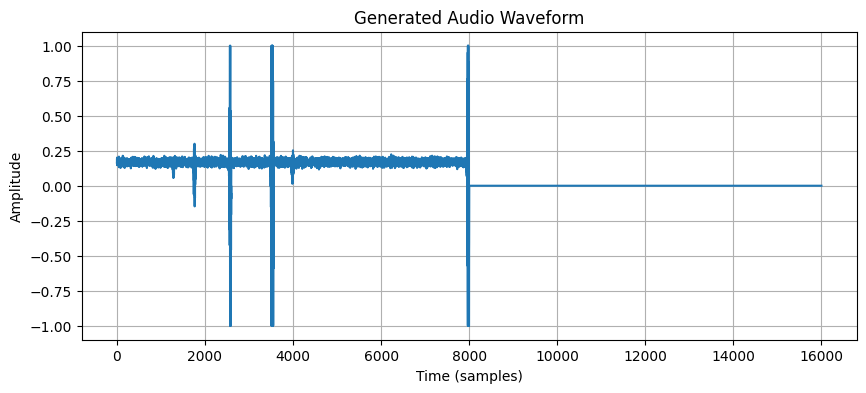

Generated audio playback:


In [14]:
# Define necessary variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextToMusicGenerationModel(embedding_dim=512)
model.to(device)

# Try generating audio
text_prompt = "A calm piano melody with soft strings"
generated_audio = model.generate_from_text(text_prompt)
display_audio_in_colab(generated_audio)

In [15]:
def generate_and_play(model, prompt, duration=10):
    model.eval()
    with torch.no_grad():
        audio = model.generate_from_text(prompt, length=duration*16000)
    audio_np = audio.squeeze()
    return ipd.Audio(audio_np, rate=16000)

# Example usage
model = TextToMusicGenerationModel()
display(generate_and_play(model, "Epic orchestral battle music with pounding drums"))


Text encoded, embedding shape: torch.Size([1, 512])
Initial noise created with shape: torch.Size([1, 1, 160000])
Step 0/50, audio range: -0.960 to 1.313
Step 10/50, audio range: -1.301 to 8.170
Step 20/50, audio range: -0.848 to 22.936
Step 30/50, audio range: -0.965 to 22.610
Step 40/50, audio range: -0.896 to 22.851
